In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
%load_ext autoreload
%autoreload 2

# Formatting your data: feature extraction from motion tracking output

In [3]:
# Create and run a project. Explore different processing parameters (smoothing, imputation)

In [4]:
my_deepof_project = deepof.data.Project(
                path=os.path.join("../../Desktop/deepOF_CSDS_tutorial_dataset/"),
                arena="circular-autodetect",
                animal_ids=["B", "W"],
                video_format=".mp4",
                exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"],
                video_scale=380,
                enable_iterative_imputation=True,
                exp_conditions={
                    '20191204_Day2_SI_JB08_Test_56': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_61': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_62': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_54': 'Nonstressed',
                    '20191204_Day2_SI_JB08_Test_63': 'Nonstressed',
                    '20191204_Day2_SI_JB08_Test_64': 'Nonstressed'
                }
)

# Set manually the edge in the polygons that we're measuring

In [5]:
# my_deepof_project = my_deepof_project.run()

In [6]:
# Save your project to avoid laborious repetitions

In [7]:
# my_deepof_project.save("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_coordinates")

In [8]:
# Load a previously saved project
my_deepof_project = deepof.data.load("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_coordinates_1667951748.pkl")

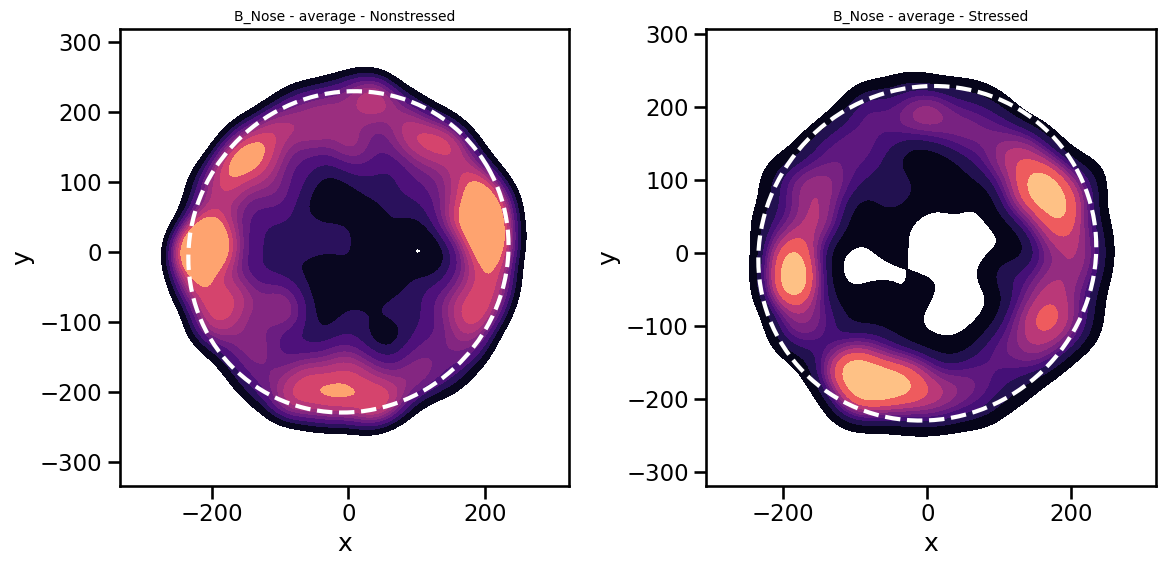

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import deepof.visuals
from matplotlib.patches import Ellipse

sns.set_context("talk")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="Nonstressed",
    ax=ax1,
    show=False,
    display_arena=True,
    experiment_id="average",
)

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="Stressed",
    ax=ax2,
    show=False,
    display_arena=True,
    experiment_id="average",
)

plt.tight_layout()
plt.show()

In [10]:
import pickle
import numpy as np
with open("../train_models/deepof_unsupervised_VQVAE_encodings_input=coords_k=100_latdim=8_kmeans_loss=0.0_run=1.pkl", "rb") as handle:
    vqvae_solution = pickle.load(handle)

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from deepof.post_hoc import get_transitions
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm_notebook as tqdm


def merge_and_smooth_clusters(
    n_clusters, centroids, embedding, concat_embedding, cluster_assignments
):
    """Merges the current clusters using a hierarchical agglomerative approach, and smoothens using a Gaussian HMM.

    Args:
        n_clusters (int): number of clusters to report.
        centroids (np.ndarray): precomputed means per cluster.
        embedding (tabdict): original deepof.TableDict object containing unsupervised embeddings.
        concat_embedding (np.ndarray): concatenated list of embeddings per animal in the dataset.
        cluster_assignments (tabdict): original deepof.TableDict object containing cluster assignments.

    Returns:
        new_soft_assignments (np.ndarray): concatenated postprocessed assignments for all animals in the dataset.
    """

    # Merge clusters ussing a hierarchical agglomerative approach
    new_hard_assignments = AgglomerativeClustering(
        n_clusters=n_clusters, compute_distances=True
    ).fit_predict(centroids)
    cluster_predictor = LinearDiscriminantAnalysis().fit(
        centroids, new_hard_assignments
    )
    centroids = cluster_predictor.means_
    new_soft_assignments = cluster_predictor.predict_proba(concat_embedding)

    # Rebuild the soft assignments dictionary per experimental animal
    new_soft_assignments = np.split(
        new_soft_assignments,
        np.cumsum([i.shape[0] for i in embedding.values()]),
    )
    new_soft_assignments = {
        key: val for key, val in zip(cluster_assignments.keys(), new_soft_assignments)
    }

    # Smooth assignments across time using a Gaussian HMM on the embeddings, with priors based on the clustering results
    for key, val in tqdm(new_soft_assignments.items()):

        hmm = GaussianHMM(
            startprob_prior=np.unique(val.argmax(axis=1), return_counts=True)[1],
            transmat_prior=get_transitions(val.argmax(axis=1), n_states=n_clusters) + 10,
            means_prior=centroids,
            n_components=n_clusters,
            covariance_type="diag",
            n_iter=100,
            tol=0.0001,
        )
        
        hmm.fit(embedding[key].numpy())
        new_soft_assignments[key] = hmm.predict_proba(embedding[key].numpy())

    return new_soft_assignments


def cluster_postprocessing(embedding, cluster_assignments, n_clusters="auto"):
    """Merges clusters using a hierarchical approach.

    Args:
        embedding (list): list of embeddings per animal in the dataset.
        cluster_assignments (list): list of cluster assignments per animal in the dataset.
        n_clusters (int): number of clusters to report.

    Returns:
        new_soft_assignments (list): list of new (merged) cluster assignments.

    """
    # Concatenate embeddings and cluster assignments in to unique np.ndarray objects
    concat_embedding = np.concatenate([tensor.numpy() for tensor in embedding.values()])
    hard_assignments = np.concatenate(
        [tensor.numpy().argmax(axis=1) for tensor in cluster_assignments.values()]
    )

    assert concat_embedding.shape[0] == hard_assignments.shape[0]

    # Get cluster centroids from the concatenated embeddings
    centroids = []
    for cluster in range(np.max(hard_assignments)):
        centroid = concat_embedding[hard_assignments == cluster]
        if len(centroid) == 0:
            continue
        centroid = np.mean(centroid, axis=0)
        centroids.append(centroid)

    centroids = np.stack(centroids)

    # Merge centroids using a hierarchical approach with the given resolution, and soft-assign instances to clusters
    if isinstance(n_clusters, int):
        new_soft_assignments = merge_and_smooth_clusters(
            n_clusters, centroids, embedding, concat_embedding, cluster_assignments
        )

    else:
        raise NotImplementedError

    return new_soft_assignments

In [12]:
from hmmlearn.hmm import GaussianHMM

new_ass = cluster_postprocessing(
    vqvae_solution[0], 
    vqvae_solution[1],
    n_clusters=12
)
hcc = new_ass['20191203_Day1_SI_JB08_Test_54'].argmax(axis=1)

/var/folders/wf/msmt6cvx5xl9t0p2qjd1tn65jtl6l8/T/ipykernel_1738/3239733948.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for key, val in tqdm(new_soft_assignments.items()):


  0%|          | 0/53 [00:00<?, ?it/s]

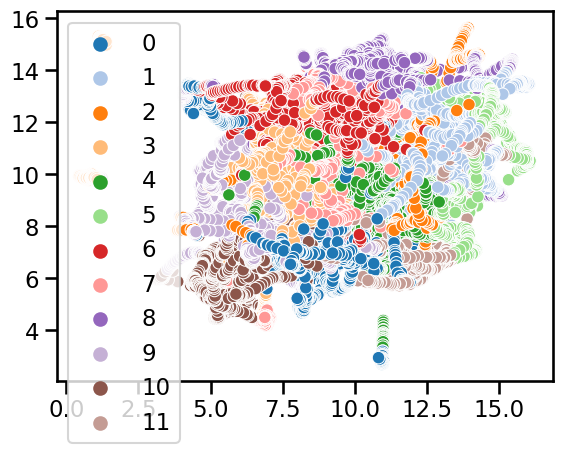

In [14]:
import umap

# Cluster on the original embedding space
new_emb = umap.UMAP(n_components=2, n_neighbors=75).fit_transform(vqvae_solution[0]['20191203_Day1_SI_JB08_Test_54'])

sns.scatterplot(x=new_emb[:, 0], y=new_emb[:, 1], hue=hcc, palette="tab20")

plt.show()

In [15]:
# How prevalent are these clusters?
from collections import Counter
print(Counter(hcc))

new_ass = hcc

Counter({1: 1570, 3: 1562, 4: 1488, 9: 1466, 6: 1394, 7: 1325, 10: 1233, 0: 1198, 8: 1164, 2: 886, 11: 864, 5: 825})


In [16]:
# How often does the model change clusters?
from collections import defaultdict

lengths = defaultdict(list)
cur = 0
for i in range(1, len(new_ass)):
    if new_ass[i-1] == new_ass[i]:
        cur += 1
    else:
        lengths[new_ass[i-1]].append(cur)
        cur = 1

{key:np.mean(val) for key, val in lengths.items()}

{10: 37.333333333333336,
 3: 16.617021276595743,
 9: 24.433333333333334,
 7: 13.802083333333334,
 4: 16.719101123595507,
 0: 22.30188679245283,
 2: 30.551724137931036,
 5: 26.612903225806452,
 6: 21.12121212121212,
 8: 27.714285714285715,
 1: 26.166666666666668,
 11: 21.6}

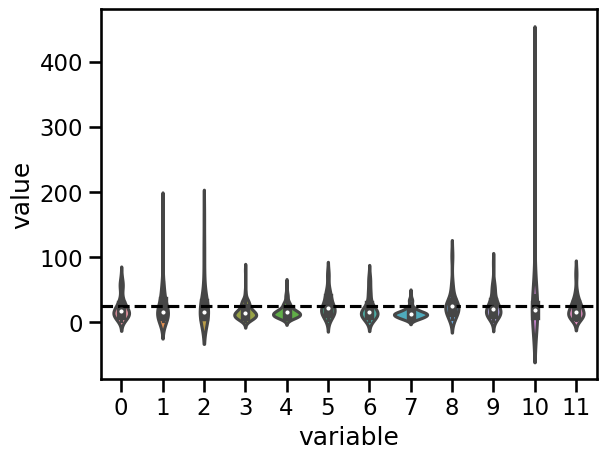

In [17]:
import pandas as pd

# Duration histograms per cluster
lengths_df = pd.DataFrame([lengths]).melt().explode("value").astype(int)
sns.violinplot(data=lengths_df, x="variable", y="value")

plt.axhline(25, linestyle="--", color="black")
        
plt.show()

In [22]:
my_deepof_project.get_coords(speed=1)['20191204_Day2_SI_JB08_Test_54']["B_Center"]

0        0.000
1        0.000
2        0.000
3        0.000
4        1.836
         ...  
14994    6.914
14995    5.343
14996    5.600
14997    5.434
14998    3.782
Name: B_Center, Length: 14999, dtype: float64

In [195]:
coords = my_deepof_project.get_coords(speed=1)
coords._animal_ids

['B', 'W']

In [191]:
# Check scales across animals. Can we detect to which animal a given time series belongs to?
# Once happy with a solution, check that all animals show comparable cluster interpretations.

# Add preprocessing options to include multiple animals, concatenated and together in a graph

cc = my_deepof_project.get_coords(center="Center", align="Spine_1")
tt = cc.preprocess(
    window_size=100, 
    window_step=100, 
    test_videos=1, 
    handle_ids="concat", # "concat" uses bps from != animals as features, "split" 
)

TypeError: preprocess() got an unexpected keyword argument 'handle_ids'

In [190]:
tt[0].shape

(749, 100, 38)

In [181]:
# UNSUPERVISED PENSING LIST:

# IMPLEMENT CONTRASTIVE MODELS
# ADD SPEED REGULARIZATION (PREDICT SPEED FROM THE LATENT SPACE, TO MAKE THE EMBEDDING STRUCTURE REFLECT IT)
# ADD PREPROCESSING OPTIONS TO HANDLE MULTIPLE ANIMALS -> PREPROCESS ALL ANIMALS TOGETHER ; PREPROCESS THE WHOLE SYSTEM AS A GRAPH

In [187]:
cons = my_deepof_project.deep_unsupervised_embedding(tt, embedding_model="contrastive", epochs=5, encoder_type="TCN")



2022-11-25 12:22:26.840455: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-25 12:22:26.840468: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-25 12:22:26.841075: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


Epoch 1/5
 1/11 [=>............................] - ETA: 1:06 - total_loss: 0.1034 - pos_similarity: 0.2670 - neg_similarity: 0.0387

2022-11-25 12:22:33.879945: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-25 12:22:33.879957: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


 3/11 [=======>......................] - ETA: 22s - total_loss: 0.1693 - pos_similarity: 0.1851 - neg_similarity: 0.0646

2022-11-25 12:22:39.355970: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-25 12:22:39.367428: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-25 12:22:39.380168: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_contrastive_encodings_input_type=coords_kmeans_loss=1.0_encoding=4_k=10_20221125-122226/plugins/profile/2022_11_25_12_22_39

2022-11-25 12:22:39.389328: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /Users/lucas_miranda/PycharmProjects/deepof/unsupervised_trained_models/fit/deepof_unsupervised_contrastive_encodings_input_type=coords_kmeans_loss=1.0_encoding=4_k=10_20221125-122226/plugins/profile/2022_11_25_12_22_39/MC-C9791E.local.trace.json.gz
2022-11-25 12:22:39.410851: I tensorflow/core/profiler/rpc/c

11/11 [==============================] - ETA: 0s - total_loss: 0.1821 - pos_similarity: 0.2115 - neg_similarity: 0.0672

2022-11-25 12:22:40.109599: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 [==============================] - 14s 724ms/step - total_loss: 0.1821 - pos_similarity: 0.2115 - neg_similarity: 0.0672 - val_total_loss: 0.1488 - val_pos_similarity: 0.5274 - val_neg_similarity: 0.2804 - lr: 0.0010
Epoch 2/5
11/11 [==============================] - 1s 90ms/step - total_loss: 0.1539 - pos_similarity: 0.2673 - neg_similarity: 0.0698 - val_total_loss: 0.2469 - val_pos_similarity: 0.8882 - val_neg_similarity: 0.8423 - lr: 0.0010
Epoch 3/5
11/11 [==============================] - 1s 89ms/step - total_loss: 0.1153 - pos_similarity: 0.3081 - neg_similarity: 0.0690 - val_total_loss: 0.2465 - val_pos_similarity: 0.9500 - val_neg_similarity: 0.9120 - lr: 0.0010
Epoch 4/5
11/11 [==============================] - 1s 91ms/step - total_loss: 0.0866 - pos_similarity: 0.3310 - neg_similarity: 0.0604 - val_total_loss: 0.2502 - val_pos_similarity: 0.9543 - val_neg_similarity: 0.9226 - lr: 0.0010
Epoch 5/5
11/11 [==============================] - 1s 89ms/step - total_loss: 0.0624

In [172]:
import umap
cons = umap.UMAP(n_components=2).fit_transform(cons(tt[0][:, :50]))

In [178]:
sns.scatterplot(x=cons[:, 0], y=cons[:, 1])

TypeError: 'Contrastive' object is not subscriptable

In [ ]:
tt = np.split(np.concatenate(tt), np.cumsum([i.shape[0] for k,i in vqvae_solution[0].items() if k in list(cc.keys())]))

for i in tt:
    print(i.shape)
    print(np.max(np.abs(i.mean(axis=0))))
    print(np.mean(np.abs(i.std(axis=0))))


In [ ]:
# Do cluster assignments differ significantly across animals? Can we detect the animal from the assignments' histogram?
# Leave for later, when implementing the cluster enrichment and viz functions

In [129]:
emb = umap.UMAP(n_components=2, n_neighbors=75).fit_transform(np.concatenate([
    np.zeros([12, 8]),
    vqvae_solution[0]['20191203_Day1_SI_JB08_Test_54'],
    np.zeros([12, 8]),
    ]
))
#clust_ass=np.concatenate([
#    np.zeros(12), hcc,  np.zeros(12)]).astype(int)

In [126]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=emb,
    #cluster_assignments=clust_ass,
    animal_id="B",
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=50,
    selected_cluster=0,
    dpi=60,
    center="Center",
    align="Spine_1",
    #embedding=[emb_B, emb_W],
)

html = display.HTML(video)
display.display(html)
plt.close()

AssertionError: there should be one embedding per row in data

In [ ]:
# Single animal display

In [ ]:
emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords().filter_id("B")['20191204_Day2_SI_JB08_Test_56'])

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    animal_id="B",
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords(center="Center", align="Spine_1").filter_id("B")['20191204_Day2_SI_JB08_Test_56'])

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    center="Center",
    align="Spine_1",
    animal_id="B",
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
# Get and plot coordinates, distances, angles, and areas. Try and visualizing different centering and rotations

In [ ]:
my_deepof_project.get_coords(polar=True)['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_distances()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_angles()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_areas()

In [ ]:
my_deepof_project.get_areas()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
# Show how to merge different feature objects

my_deepof_project.get_coords().pca()